In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os

train = pd.read_json("all/train.json")
test = pd.read_json("all/test.json")

train['all_ingredients'] = train['ingredients'].apply(",".join)
test['all_ingredients'] = test['ingredients'].apply(",".join)

# Finding Similar Dishes 

In [19]:
# Example df.iterrows()

inp = [{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}]
df = pd.DataFrame(inp)
print("DataFrame:\n", df)

# DataFrame.iterrows - это генератор, который выдает как индекс, так и строку
print("\nOur result: ")
for index, row in df.iterrows():
    print(row['c1'], row['c2'])


DataFrame:
    c1   c2
0  10  100
1  11  110
2  12  120

Our result: 
10 100
11 110
12 120


In [20]:
ingList = []

for index, row in train.iterrows():
    ingre = row['ingredients']
    
    for i in ingre:
        if i not in ingList:
            ingList.append(i)
        
def binary(ListIngredient):
    binaryList = []
    
    for item in ingList:
        if item in ListIngredient:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

train['bin_ingredients'] = train['ingredients'].apply(lambda x: binary(x))

print(train.head())

       cuisine     id                                        ingredients  \
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...   
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...   
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3       indian  22213                [water, vegetable oil, wheat, salt]   
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...   

                                     all_ingredients  \
0  romaine lettuce,black olives,grape tomatoes,ga...   
1  plain flour,ground pepper,salt,tomatoes,ground...   
2  eggs,pepper,salt,mayonaise,cooking oil,green c...   
3                     water,vegetable oil,wheat,salt   
4  black pepper,shallots,cornflour,cayenne pepper...   

                                     bin_ingredients  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...  
2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0

__scipy.spatial.distance.cosine(u, v, w=None)__
    
    Compute the Cosine distance between 1-D arrays.
    The Cosine distance between u and v, is defined as
   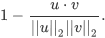

In [21]:
from scipy import spatial

def Simiratity(Id1, Id2):
    a = train.iloc[Id1]
    b = train.iloc[Id2]

    A = a['bin_ingredients']
    B = b['bin_ingredients']
    
    distance = spatial.distance.cosine(A,B)
    
    return distance, Id2

### Dishes Similar to Dish No 1

In [24]:
print("Cuisine: ", train.iloc[1]['cuisine'], "\nId_cuisine: ", train.iloc[1]['id'], "\nIngredients: ", train.iloc[1]['all_ingredients'], "\n")

food = []
for i in train.index:
    food.append(Simiratity(1, i))

common_ingredients = sorted(food, key=lambda x: x[0])
indexes = []
for i in range(len(common_ingredients)):
    indexes.append(common_ingredients[i][1])
    
train_similar = train.iloc[indexes]
train_similar.iloc[i]
print("\nTop-15 Dishes Similar to Dish No 1: \n")
for i in range(0, 5):
    print("Cuisine: ", train_similar.iloc[i]['cuisine'], "\nId_cuisine: ", train_similar.iloc[i]['id'], "\nIngredients: ", train_similar.iloc[i]['all_ingredients'], "\n\n")


Cuisine:  southern_us 
Id_cuisine:  25693 
Ingredients:  plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,vegetable oil 


Top-15 Dishes Similar to Dish No 1: 

Cuisine:  southern_us 
Id_cuisine:  25693 
Ingredients:  plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,vegetable oil 


Cuisine:  british 
Id_cuisine:  42852 
Ingredients:  eggs,vegetable oil,onions,ground black pepper,sausages,milk,salt,mustard,flour,thyme 


Cuisine:  southern_us 
Id_cuisine:  46403 
Ingredients:  ground black pepper,cucumber,eggs,salt,milk,all-purpose flour,vegetable oil 


Cuisine:  southern_us 
Id_cuisine:  42450 
Ingredients:  flour,milk,salt,eggs,vegetable oil,yellow corn meal,baking powder 


Cuisine:  southern_us 
Id_cuisine:  1915 
Ingredients:  ground black pepper,yellow corn meal,salt,olive oil,green tomatoes 




# Top Bigrams by Cuisines

ntkl - __Natural Language Toolkit__
http://www.nltk.org/
    
    

In [35]:
import nltk
nltk.download('punkt')

from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bohda\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


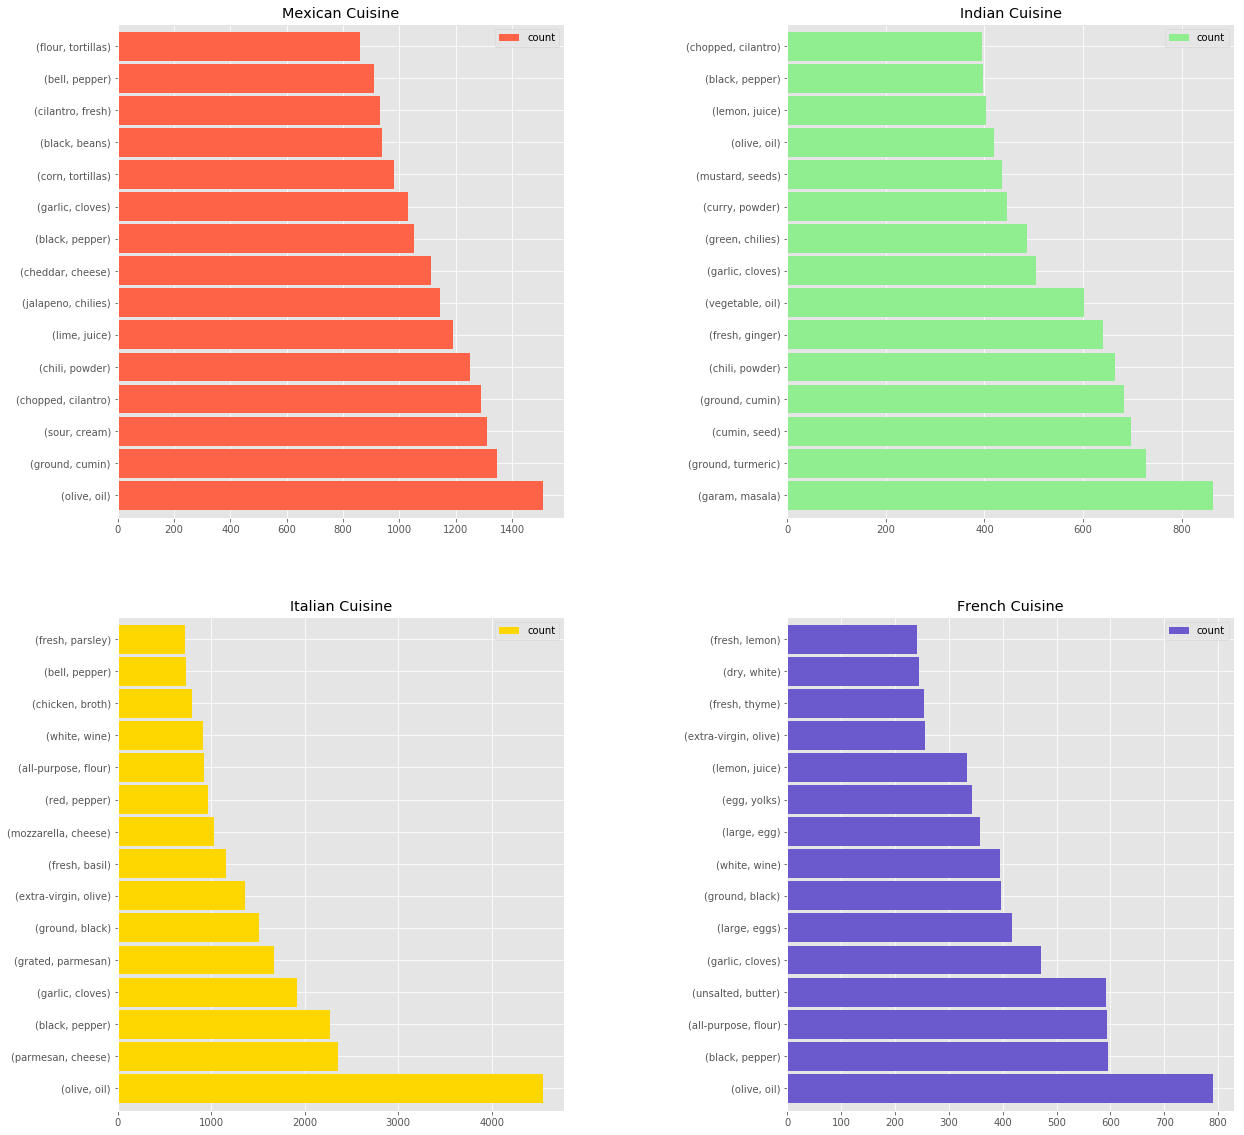

In [36]:
train['for ngrams'] = train['all_ingredients'].str.replace(',',' ')

f, ax = plt.subplots(2, 2, figsize=(20,20))

def ingre_cusine(cuisine):
    frame = train[train['cuisine']==cuisine]
    common = list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]


ingre_cusine('mexican').plot.barh(ax=ax[0,0],width=0.9,color='tomato')
ax[0,0].set_title('Mexican Cuisine')

ingre_cusine('indian').plot.barh(ax=ax[0,1],width=0.9,color='lightgreen')
ax[0,1].set_title('Indian Cuisine')

ingre_cusine('italian').plot.barh(ax=ax[1,0],width=0.9,color='gold')
ax[1,0].set_title('Italian Cuisine')

ingre_cusine('french').plot.barh(ax=ax[1,1],width=0.9,color='slateblue')
ax[1,1].set_title('French Cuisine')

plt.subplots_adjust(wspace=0.5)

# Network Diagrams for Bigrams

In [47]:
import networkx as nx

def generate_ngrams(text, n):
    words = text.split(' ')
    iterations = len(words) - n + 1
    for i in range(iterations):
        yield words[i:i + n]
        
def net_diagram(*cuisines):
    ngrams = {}
    
    for title in train[train.cuisine==cuisines[0]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ['count']
    ngrams_mws_df['cusine'] = cuisines[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)

    ngrams = {}
    for title in train[train.cuisine==cuisines[1]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ['count']
    ngrams_mws_df1['cusine'] = cuisines[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    
    cuisine1 = ngrams_mws_df.sort_values('count',ascending=False)[:25]
    cuisine2 = ngrams_mws_df1.sort_values('count',ascending=False)[:25]
    
    df_final = pd.concat([cuisine1,cuisine2])
    g = nx.from_pandas_edgelist(df_final, source='cusine', target='index')
    
    cmap = plt.cm.RdYlGn
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final['count'].values*8, cmap = cmap, node_color=colors, edge_color='grey', font_size=15, width=3)
    
    plt.title("Top 25 Bigrams for %s and %s" %(cuisines[0],cuisines[1]), fontsize=30)
    plt.gcf().set_size_inches(30,30)
    plt.show()
    plt.savefig('network.png')


c:\users\bohda\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


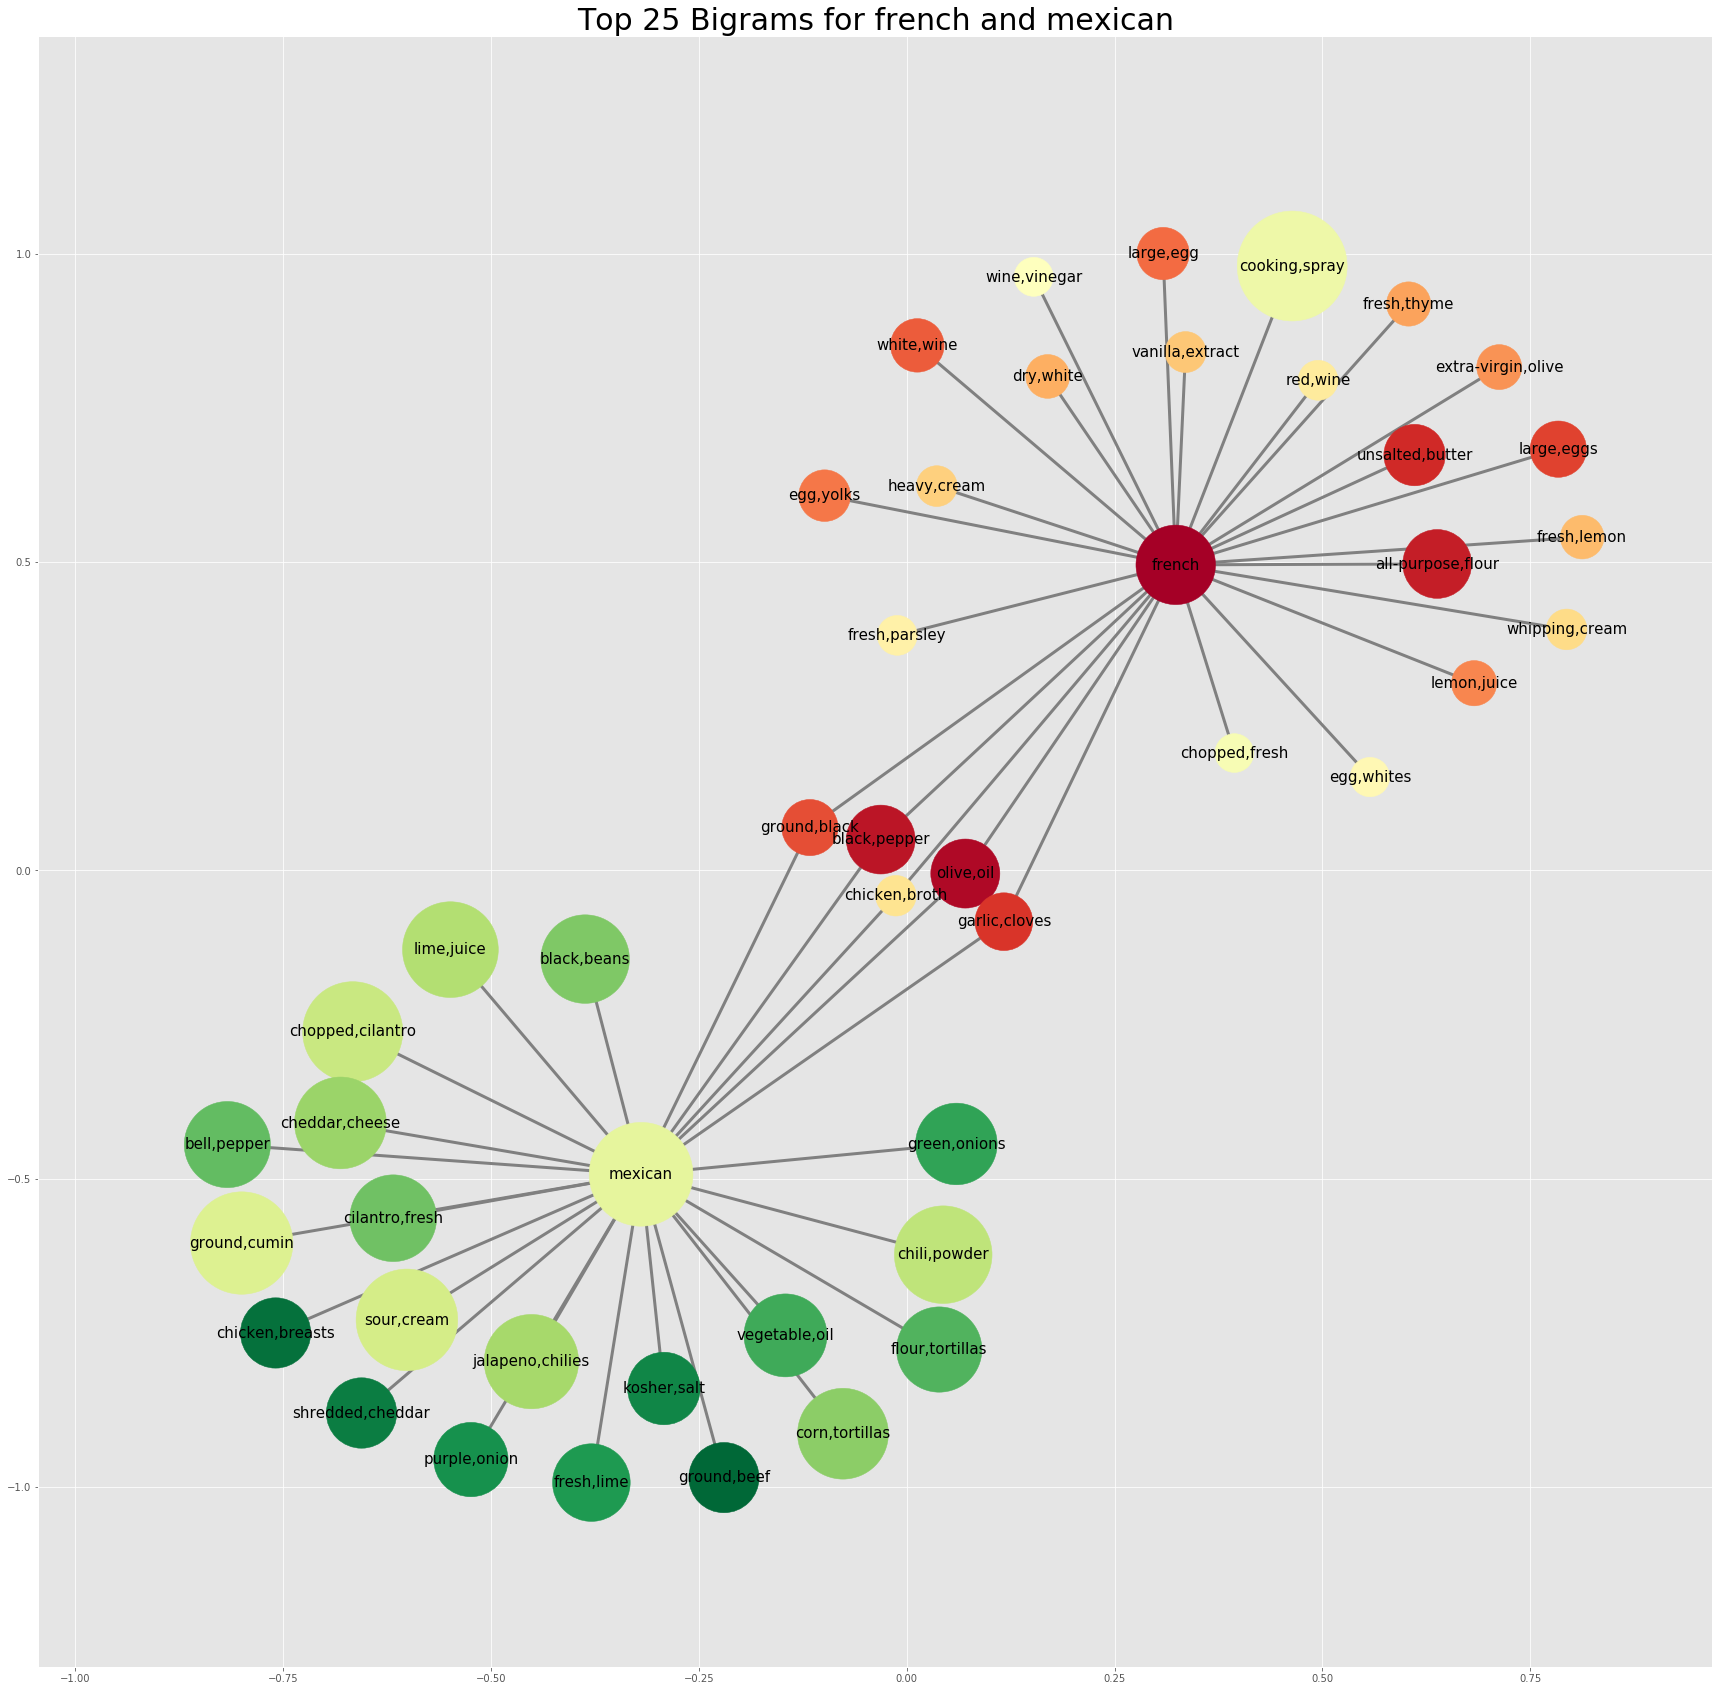

<Figure size 432x288 with 0 Axes>

In [48]:
net_diagram('french','mexican')

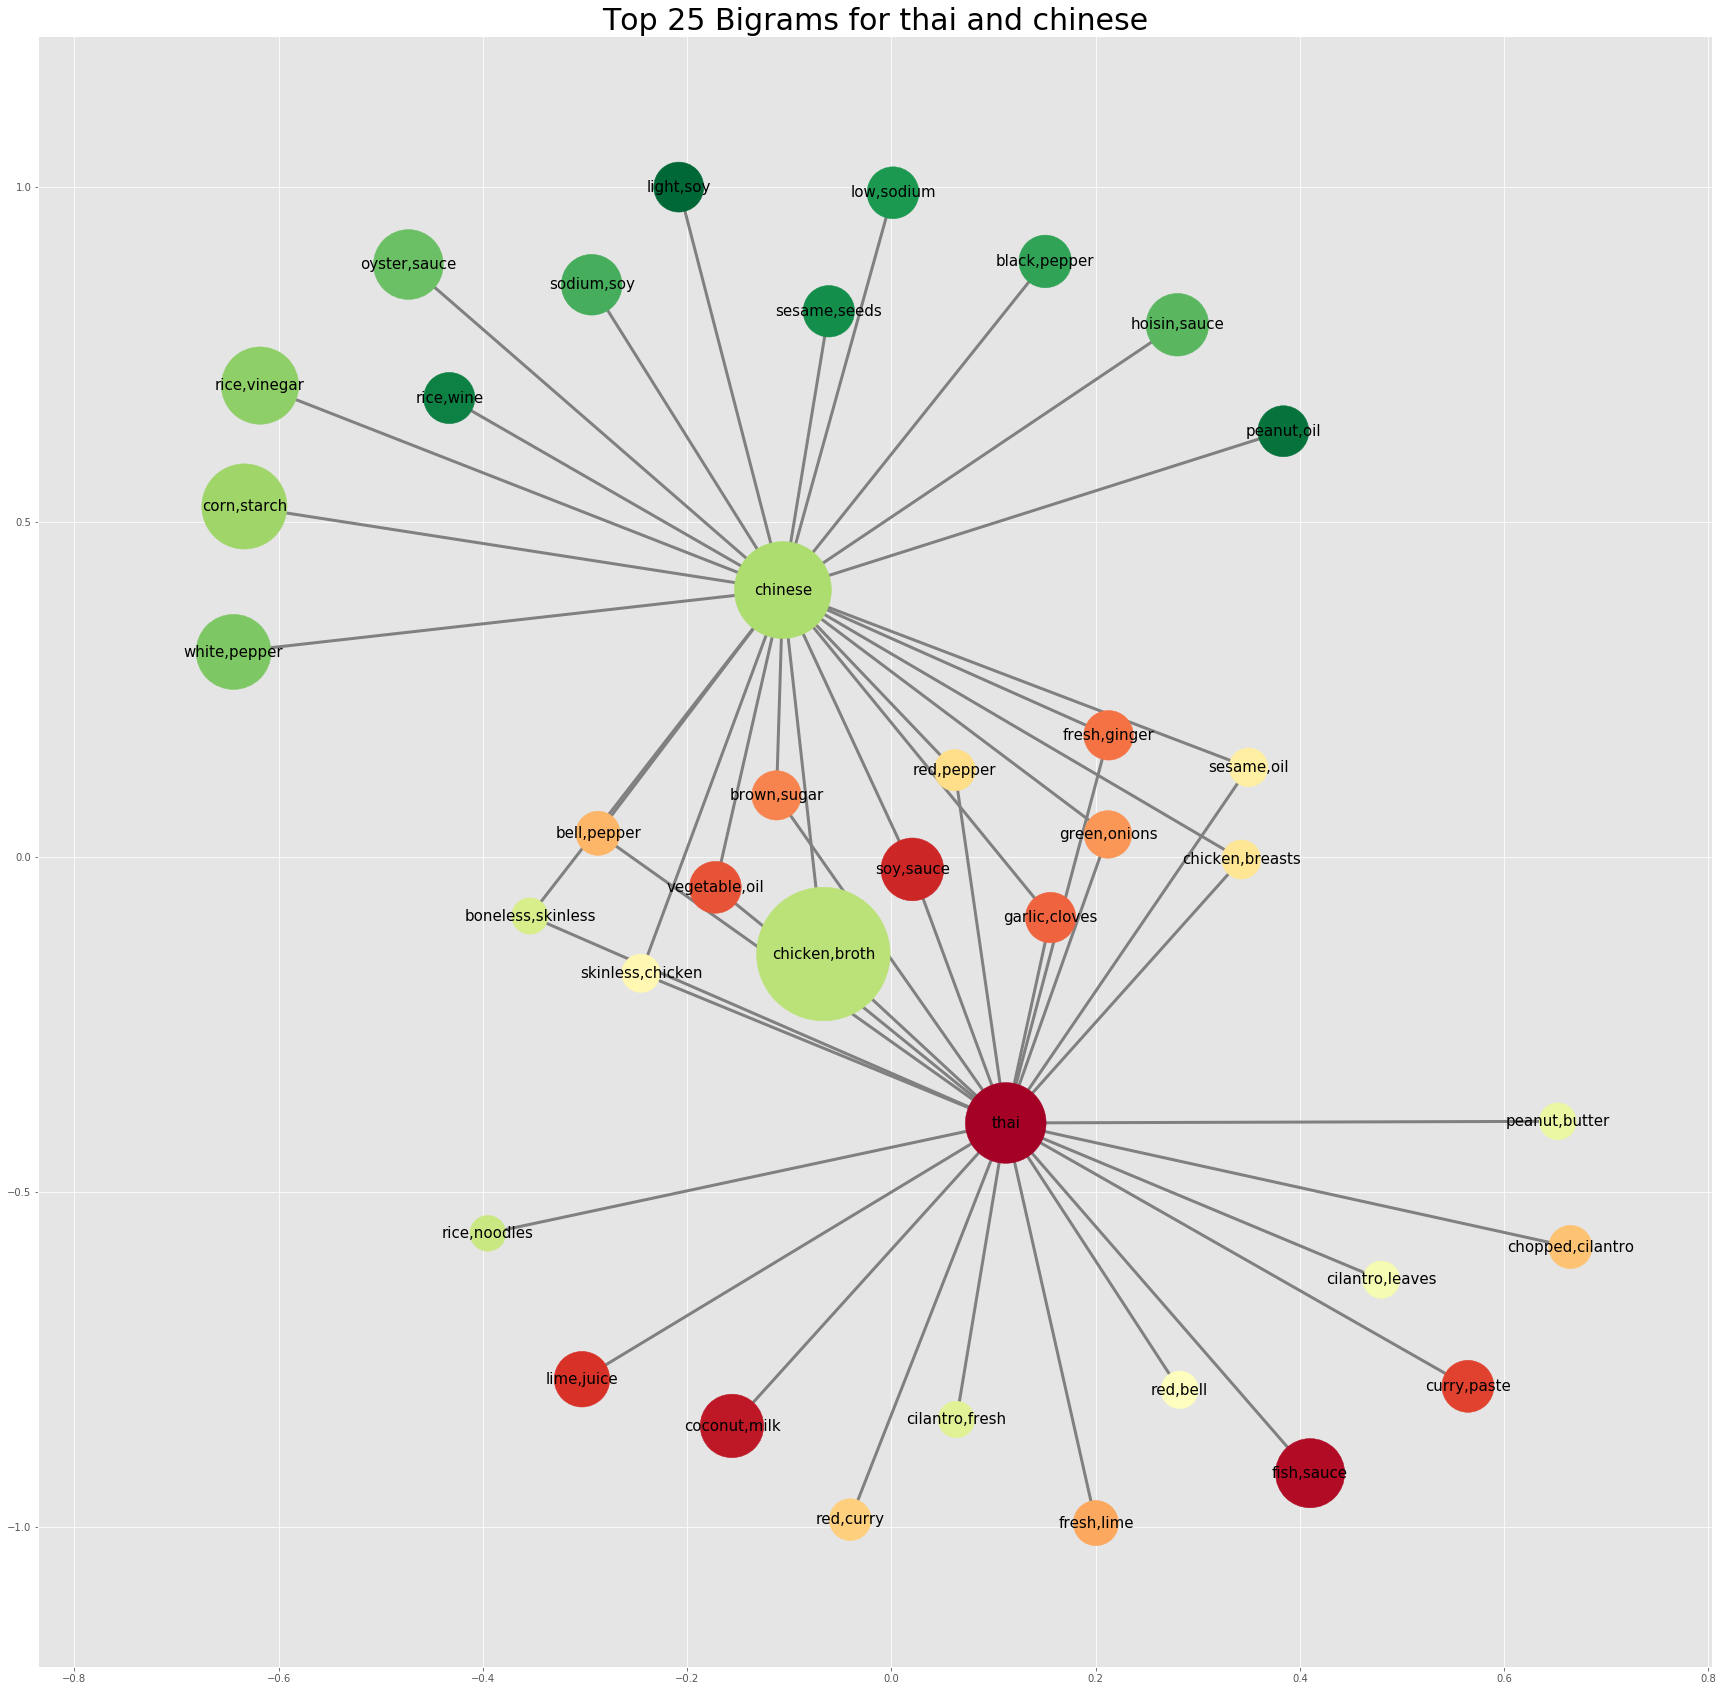

<Figure size 432x288 with 0 Axes>

In [49]:
net_diagram('thai','chinese')

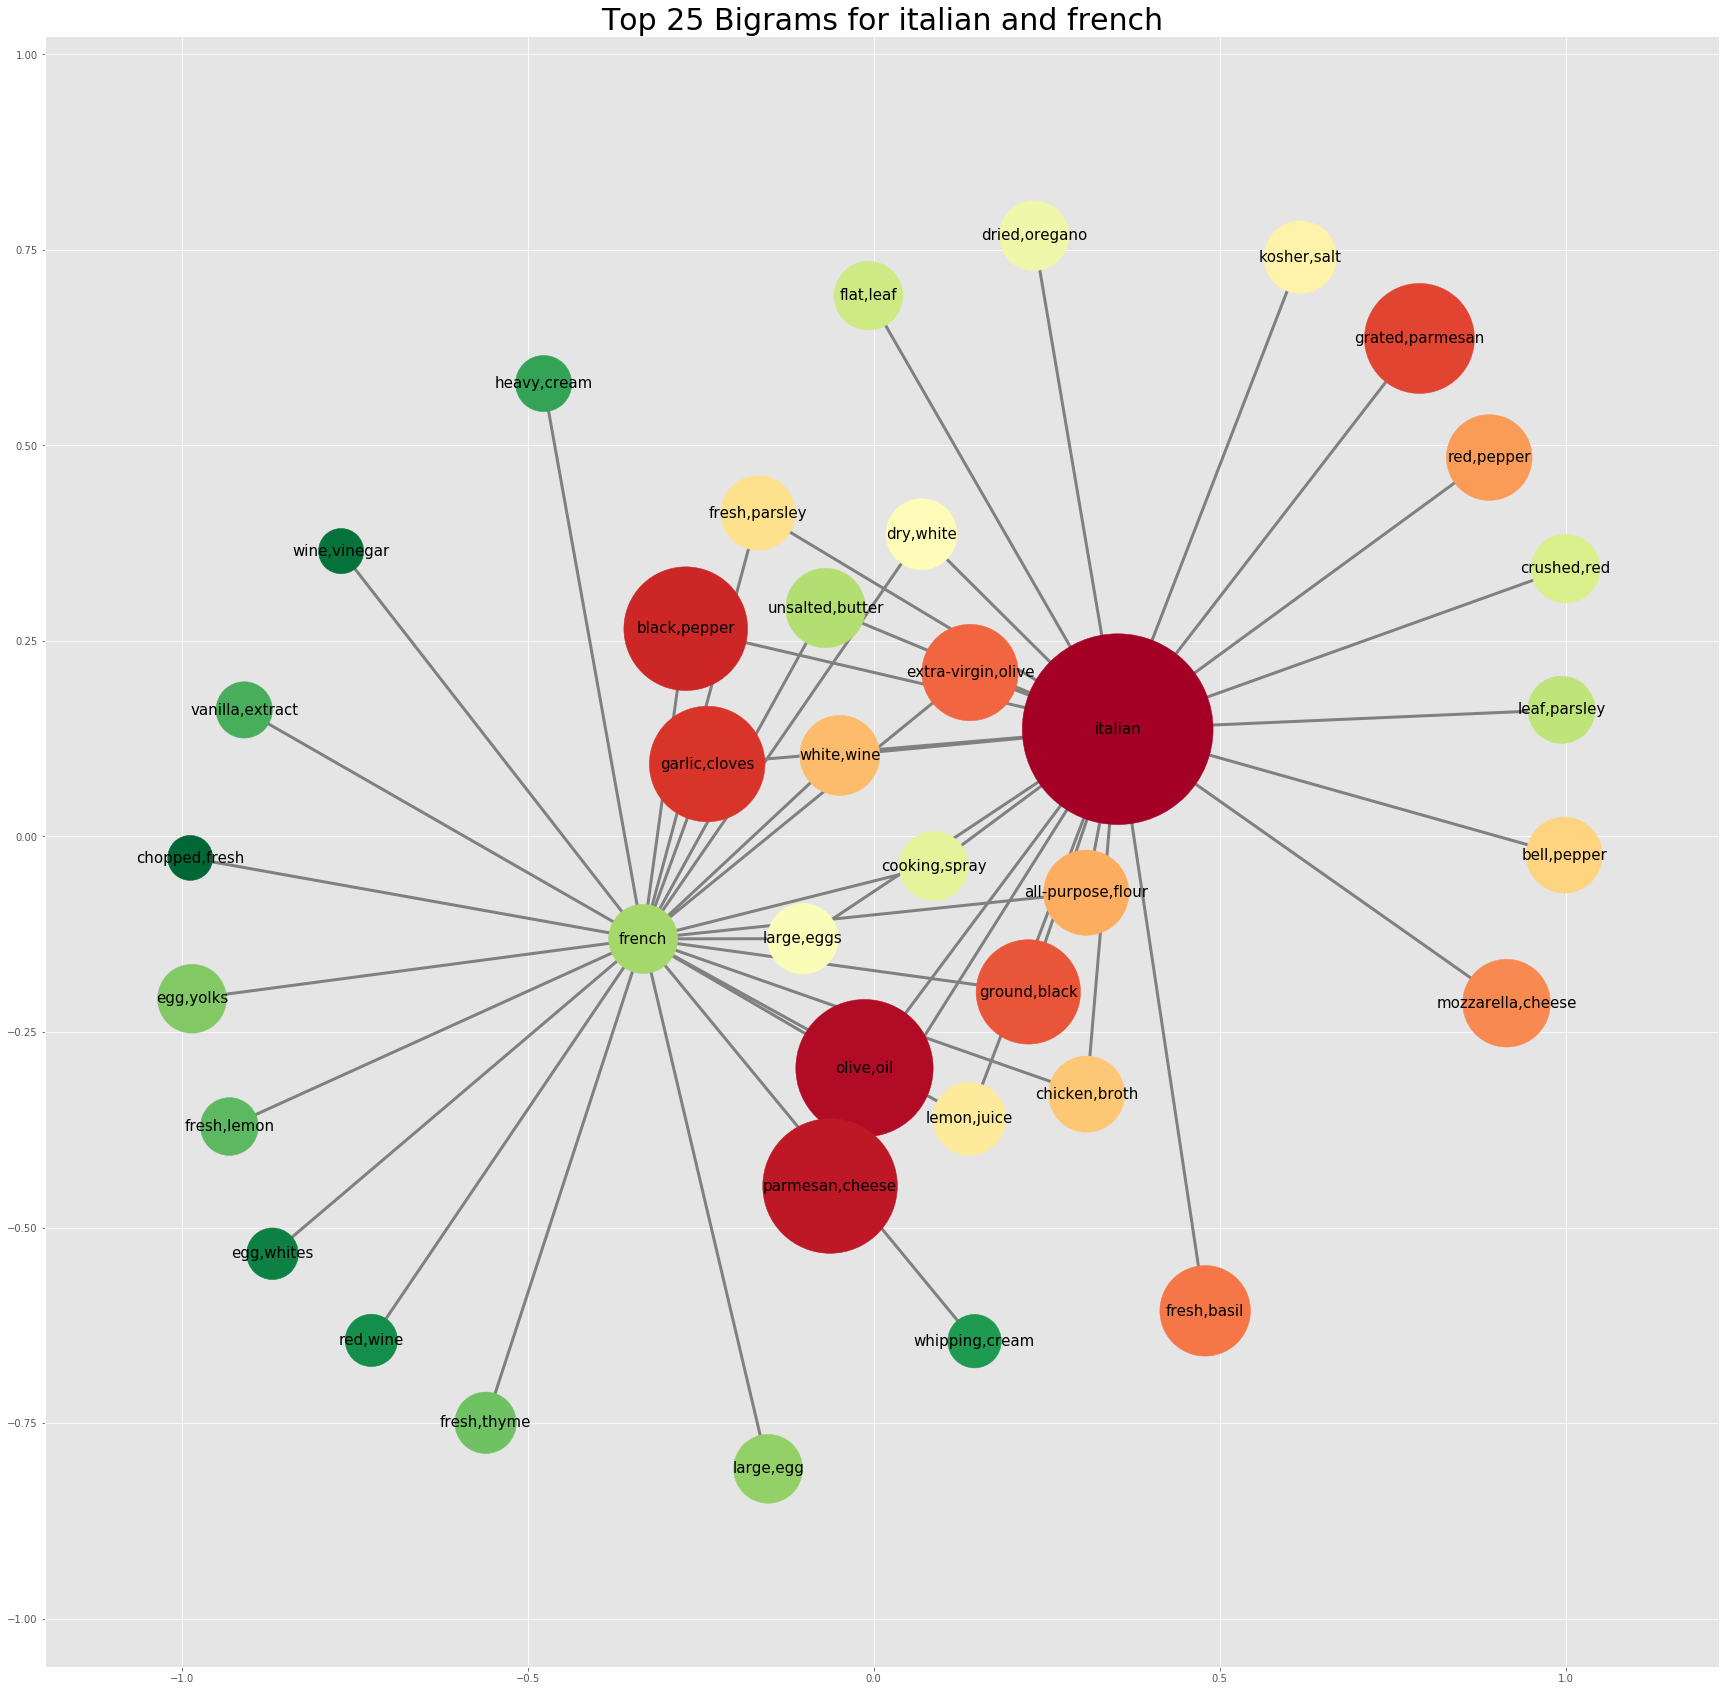

<Figure size 432x288 with 0 Axes>

In [52]:
net_diagram('italian','french')